#  <center> Semi-supervised kidney segmentation with Independent Component Analysis (ICA) </center> #

In [34]:
import numpy as np
from scipy import signal
import nibabel as nib
from sklearn.decomposition import FastICA
from nilearn.plotting import plot_stat_map, plot_roi, show
from nilearn import image


In [35]:
'''
Define input file path and label path, path of folder to save data,
labels of kidneys 
'''


INPUT_FILE_NAME = 'SG2_FF02_1_flash3d_bh'

INPUT_FILE = '../sample_data/dce-mri/%s_kidMo.nii.gz' %INPUT_FILE_NAME
LABEL_FILE = '../sample_data/labels/%s_label.nii.gz' %INPUT_FILE_NAME
SAVE_PATH = '../output/'

#INPUT_FILE = '/home/kasia/Project_kidney/nifti/SG2_kidMo/%s_kidMo.nii.gz' \
#%INPUT_FILE_NAME
#LABEL_FILE = '/home/kasia/Project_kidney/nifti/magisterka_labels/%s_label.nii.gz' \
#%INPUT_FILE_NAME
#SAVE_PATH = '/home/kasia/Project_kidney/nifti/output/'

LEFT_KIDNEY_LABEL = 1
RIGHT_KIDNEY_LABEL = 2

organ_names = {LEFT_KIDNEY_LABEL: 'left kidney',
                RIGHT_KIDNEY_LABEL: 'right kidney'}

EXAMINED_ORAGAN_LABEL = LEFT_KIDNEY_LABEL

In [36]:
'''
Define function for computation of timecourses 
for every voxel included in specific label
'''

def computeTimecourses(label, dce_mri_data):   
    print ('Computing timecourses of %s. Be patient :)' % organ_names[label])
    
    organ_indices = np.where(label_data == label)
    (n_samples, n_features) = (organ_indices[0].size, timeslice_count)
    voxels_timecourses = np.zeros((n_samples, n_features))
    voxel_number = 0

    for voxel in zip(organ_indices[0],organ_indices[1],organ_indices[2]):
        
        voxel_timecourse = np.zeros((timeslice_count), np.float32)
        x, y, z = voxel
        
        for timeslice_index in range(timeslice_count):
            time_signal_value = dce_mri_data[x,y,z,timeslice_index]
            voxel_timecourse[timeslice_index] = time_signal_value
            
        #voxel_timecourse = removeBaseline(voxel_timecourse)
        #voxel_timecourse = signal.medfilt(voxel_timecourse, kernel_size=5)
        voxels_timecourses[voxel_number, :] = voxel_timecourse[:]
        
        voxel_number += 1
    print("Done!!!")
    return voxels_timecourses, organ_indices


In [37]:
# Load input file and label file

dce_mri = nib.load(INPUT_FILE) 
dce_mri_data = dce_mri.get_data()

label = nib.load(LABEL_FILE) 
label_data = label.get_data()

timeslice_count = dce_mri_data.shape[3]

t = np.arange(0,74, 1)

In [38]:
'''
Create a matrix of timecourses m x p,
where m is the number of voxels and p is the number of time points
'''

kidney_timecourses_temporal, kidney_indices  = \
computeTimecourses(EXAMINED_ORAGAN_LABEL, dce_mri_data)

# Standarize data

kidney_timecourses_temporal  = kidney_timecourses_temporal.T
kidney_timecourses_temporal -= kidney_timecourses_temporal.mean(axis=0)
kidney_timecourses_temporal /= kidney_timecourses_temporal.std(axis=0)
kidney_timecourses_temporal  = kidney_timecourses_temporal.T

Computing timecourses of left kidney. Be patient :)
Done!!!


In [39]:
### Perform ICA ###

# Define number of components

n_components = 5

ica = FastICA(n_components=n_components, 
              #algorithm = 'deflation', 
              max_iter=500)
s_temporal = ica.fit_transform(kidney_timecourses_temporal).T


In [40]:
# Normalize estimated components, calculation of Z-score

s_temporal -= s_temporal.mean(axis=0)
s_temporal /= s_temporal.std(axis=0)
s_temporal = s_temporal.T

In [41]:
# Transform the independent components values back into image space

components_img_temporal_data = np.zeros((label.shape[0], label.shape[1], 
                                        label.shape[2], n_components)) 


for component in range(n_components):
    
    for (x, y, z, component_value) in zip(kidney_indices[0],kidney_indices[1],
        kidney_indices[2], s_temporal[:,component]):
        
        components_img_temporal_data[x,y,z,component] = component_value
        

In [42]:
# Save the image in new NIfTI file

label_header = label.header
label_affine = label.affine

components_img_temporal = nib.Nifti1Image(dataobj=components_img_temporal_data,
                            affine=label_affine,
                            header=label_header)

components_filename = '%s_components.nii.gz' %INPUT_FILE_NAME
save_file = SAVE_PATH + components_filename
nib.save(components_img_temporal, save_file)
print ('Segmented kidney saved as', components_filename)   

Segmented kidney saved as SG2_FF02_1_flash3d_bh_components.nii.gz


Component 0


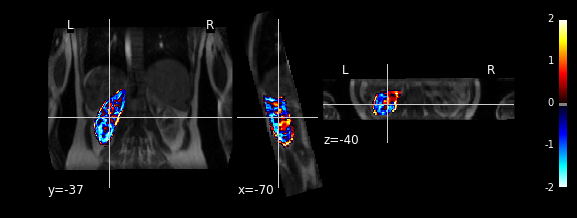

Component 1


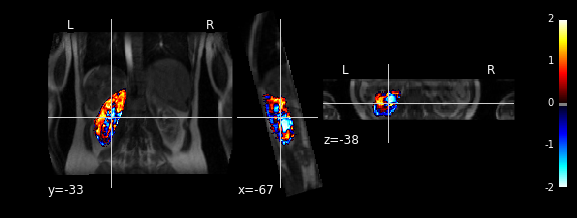

Component 2


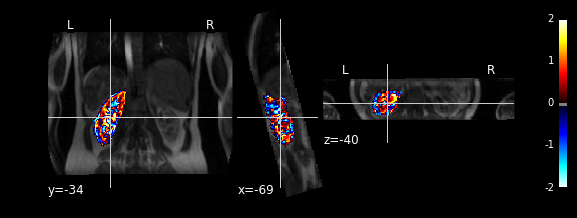

Component 3


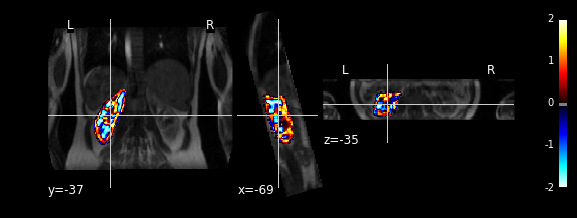

Component 4


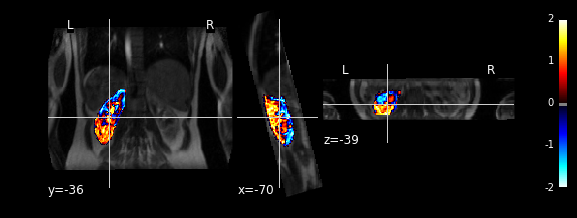

In [43]:
# Visualise results 

background = image.index_img(dce_mri, 13)

for component in range (n_components):
    print ('Component %d'%component)
    plot_stat_map(image.index_img(components_img_temporal, component) 
                  ,background 
                  , threshold = 0.05
                 )
    show()



In [28]:
'''
Define function for creating labels 
- threshold and correlation have to be chosen 
for specific subject and component
'''

def createLabel(component, threshold, component_correlation, label_name, 
                label_value = 1, show = True, save = True):
    label_data = np.copy(components_img_temporal_data[:,:,:, component])
    label_data[np.abs(label_data) < threshold] = 0
    negative_ind = np.where(label_data < 0)
    positive_ind = np.where(label_data > 0)
    
    if component_correlation == 'positive':
        label_data[positive_ind] = label_value
        label_data[negative_ind] = 0
        

    elif component_correlation == 'negative':
        label_data[negative_ind] = label_value
        label_data[positive_ind] = 0
        
        
    label_img = nib.Nifti1Image(dataobj = label_data,
                                affine=label_affine,
                                header=label_header)
    if show:
        plot_roi(label_img
                ,bg_img = background,
                 cmap = 'Set1'
                )

        
    if save:
        label_filename = 'SG2_FF02_1_flash3d_bh_%s.nii.gz' %label_name
        save_file = SAVE_PATH + label_filename
        nib.save(label_img, save_file)
        print ('Label saved as', label_filename)    
    

Label saved as SG2_FF02_1_flash3d_bh_medulla.nii.gz


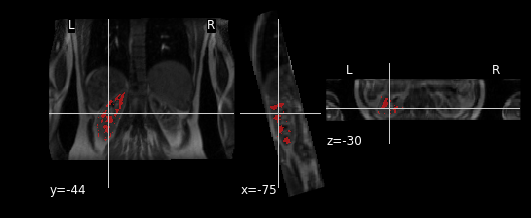

In [45]:
createLabel(3
            ,1
            ,component_correlation = 'negative'
            ,label_name = 'medulla'
            ,label_value = 1
           )

Label saved as SG2_FF02_1_flash3d_bh_cortex.nii.gz


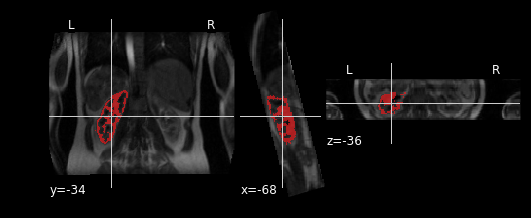

In [46]:
createLabel(3
            , 0.00
            , component_correlation = 'positive'
            , label_name = 'cortex'
            , label_value = 1
           )

Label saved as SG2_FF02_1_flash3d_bh_pelvis.nii.gz


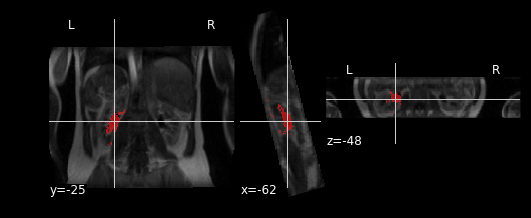

In [47]:
createLabel(1
            , 1.35
            , component_correlation = 'negative'
            , label_name = 'pelvis'
            , label_value = 1
           )

In [ ]:
# Labels require further morphological processing